In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### Load the Dataset

In [2]:
from pathlib import Path

# Load the dataset from an Excel file
file_path = Path(r"G:\College\University of Montana\Semester 4\Capstone"
                 r"\MSBA-Capstone-Riley-ORorke\data\Riley_O'Rorke_Capstone_Data.xlsx")

# Read the Excel file into a Pandas DataFrame
df = pd.read_excel(file_path, header=0)  # Ensure headers are recognized

#### Data Preprocessing

In [5]:
# Drop unnecessary columns
columns_to_drop = [
    "D.[NamePostfix]", "F.[Name]", "G1.[ParameterID]", "G1.[Name]", "G1.[OperatorMessage]",
    "G2.[ParameterID]", "G2.[Name]", "G2.[Description]", "G3.[ParameterID]", "G3.[Name]",
    "G3.[OperatorMessage]", "A.[ParameterID]", "A.[EntryTimestamp]", "A.[DataValue]",
    "A.[Description]", "B.[ParameterID]", "B.[EntryTimestamp]", "B.[DataValue]",
    "B.[Description]", "C.[ParameterID]"
]

df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors="ignore")

# Convert measurement values to numeric
df["C.[DataValue]"] = pd.to_numeric(df["C.[DataValue]"], errors="coerce")

# Convert timestamps to datetime and sort the DataFrame
df["C.[EntryTimestamp]"] = pd.to_datetime(df["C.[EntryTimestamp]"], errors="coerce")
df = (
    df.dropna(subset=["C.[EntryTimestamp]"])
    .sort_values(by="C.[EntryTimestamp]")
    .reset_index(drop=True)
)

# Outlier Removal Using Interquartile Range (IQR)
q1 = df["C.[DataValue]"].quantile(0.25)
q3 = df["C.[DataValue]"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df[(df["C.[DataValue]"] >= lower_bound) & (df["C.[DataValue]"] <= upper_bound)]
df = df.reset_index(drop=True)

# Create lag features for bore measurements
lags = [1, 2, 3, 5]
for lag in lags:
    df[f"data_value_lag{lag}"] = df["C.[DataValue]"].shift(lag)

# Create rolling mean and standard deviation features
rolling_windows = [3, 5]
for window in rolling_windows:
    df[f"rolling_mean_{window}"] = df["C.[DataValue]"].rolling(window=window).mean()
    df[f"rolling_std_{window}"] = df["C.[DataValue]"].rolling(window=window).std()

# Drop rows with NaN values due to lag and rolling calculations
df = df.dropna().reset_index(drop=True)

# Create a cycle count feature
df["cycle_count"] = range(1, len(df) + 1)

#### Train Model

In [6]:
# Define feature columns for model training
feature_columns = [
    "cycle_count", "C.[DataValue]", "data_value_lag1", "data_value_lag2",
    "data_value_lag3", "data_value_lag5", "rolling_mean_3", "rolling_std_3",
    "rolling_mean_5", "rolling_std_5"
]

# Define target variable (next cycle's bore size)
df["target_next_cycle"] = df["C.[DataValue]"].shift(-1)

# Drop the last row to avoid NaN values in the target variable
df = df.dropna().reset_index(drop=True)

# Prepare training data
X = df[feature_columns]
y = df["target_next_cycle"]

# Train a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

#### Model Evaluation


Model Evaluation Metrics:
- Mean Absolute Error (MAE): 0.0057
- Mean Squared Error (MSE): 0.0001
- Root Mean Squared Error (RMSE): 0.0079
- R-squared (R²): 0.8968


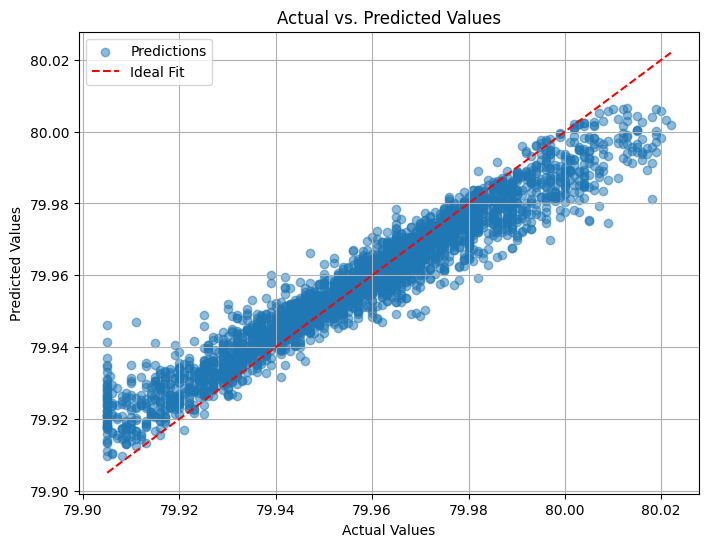

In [7]:
def evaluate_model_performance(model, X, y):
    """
    Evaluate the trained model using common regression metrics.
    
    Parameters:
    - model: Trained regression model
    - X: Feature set
    - y: True target values
    
    Returns:
    - None (prints evaluation metrics and displays a scatter plot)
    """
    # Make predictions
    y_predicted = model.predict(X)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y, y_predicted)
    mse = mean_squared_error(y, y_predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_predicted)

    # Print evaluation results
    print("\nModel Evaluation Metrics:")
    print(f"- Mean Absolute Error (MAE): {mae:.4f}")
    print(f"- Mean Squared Error (MSE): {mse:.4f}")
    print(f"- Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"- R-squared (R²): {r2:.4f}")

    # Plot actual vs. predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_predicted, alpha=0.5, label="Predictions")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red', label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.legend()
    plt.grid(True)
    plt.show()


# Call the function to evaluate the model
evaluate_model_performance(model, X, y)

#### Predict Future Wear

In [11]:
def classify_wear(change):
    """
    Classifies wear severity based on bore size change.

    Parameters:
    - change (float): Difference in bore size between cycles.

    Returns:
    - str: Wear classification label.
    """
    if change < 0.001:
        return "Normal Wear"
    elif 0.001 <= change < 0.005:
        return "Moderate Wear"
    return "Critical Wear"


def predict_future_bores(model, df, feature_columns, future_cycles=10):
    """
    Predicts bore sizes for future cycles using the trained model.

    Parameters:
    - model: Trained regression model.
    - df (pd.DataFrame): DataFrame containing past bore data.
    - feature_columns (list): List of feature column names.
    - future_cycles (int): Number of future cycles to predict.

    Returns:
    - pd.DataFrame: DataFrame containing future cycle predictions.
    """
    # Initialize DataFrame for predictions
    future_df = pd.DataFrame()
    future_df["cycle_count"] = range(
        df["cycle_count"].max() + 1, df["cycle_count"].max() + 1 + future_cycles
    )

    # Get last known values from the dataset
    last_known_values = df.iloc[-1][feature_columns].to_dict()
    predicted_bores = []

    # Predict future bore sizes
    for cycle in future_df["cycle_count"]:
        new_row = last_known_values.copy()
        new_row["cycle_count"] = cycle

        # Shift lag values forward
        for lag in [1, 2, 3, 5]:
            new_row[f"data_value_lag{lag}"] = (
                predicted_bores[-lag]
                if len(predicted_bores) >= lag
                else last_known_values["C.[DataValue]"]
            )

        # Dynamically update rolling statistics
        for window in [3, 5]:
            new_row[f"rolling_mean_{window}"] = (
                np.mean(predicted_bores[-window:])
                if len(predicted_bores) >= window
                else last_known_values[f"rolling_mean_{window}"]
            )
            new_row[f"rolling_std_{window}"] = (
                np.std(predicted_bores[-window:])
                if len(predicted_bores) >= window
                else last_known_values[f"rolling_std_{window}"]
            )

        # Convert new row to DataFrame and predict bore size
        new_X = pd.DataFrame([new_row])[feature_columns]
        predicted_bore = model.predict(new_X)[0]
        predicted_bores.append(predicted_bore)

        # Store predictions in DataFrame
        future_df.loc[future_df["cycle_count"] == cycle, "predicted_bore_size"] = predicted_bore

    # Compute bore size changes over time
    future_df["bore_size_change"] = future_df["predicted_bore_size"].diff().fillna(0)

    # Assign wear labels to future cycles
    future_df["predicted_wear_stage"] = future_df["bore_size_change"].apply(classify_wear)

    return future_df


# Generate predictions for future cycles
future_cycles = 10  # Adjust as needed
future_predictions = predict_future_bores(model, df, feature_columns, future_cycles)

# Display the predicted data
print("Future Bore Predictions DataFrame:")
print(future_predictions.head())  # Display first few rows

Future Bore Predictions DataFrame:
   cycle_count  predicted_bore_size  bore_size_change predicted_wear_stage
0         3233             79.99853           0.00000          Normal Wear
1         3234             79.99729          -0.00124          Normal Wear
2         3235             79.99771           0.00042          Normal Wear
3         3236             79.99713          -0.00058          Normal Wear
4         3237             79.99596          -0.00117          Normal Wear


#### Finalized Dataset

In [13]:
from pathlib import Path

def save_predictions_to_excel(df, future_df, output_path):
    """
    Combines actual and future bore predictions, then saves the dataset to an Excel file.

    Parameters:
    - df (pd.DataFrame): Original dataset with actual bore measurements.
    - future_df (pd.DataFrame): Predicted bore sizes and wear stages.
    - output_path (str or Path): File path where the final dataset will be saved.

    Returns:
    - pd.DataFrame: Final dataset with actual and predicted values.
    """
    # Ensure predicted columns exist in the actual dataset
    df["predicted_bore_size"] = np.nan
    df["predicted_wear_stage"] = np.nan

    # Combine actual and predicted data
    final_df = pd.concat([df, future_df], ignore_index=True)

    # Convert output path to Path object for better file handling
    output_path = Path(output_path)

    # Save final dataset to Excel
    final_df.to_excel(output_path, index=False, engine="openpyxl")

    print(f"Predictions successfully saved to: {output_path}")

    return final_df


# Define output file path
output_file_path = Path(
    r"G:\College\University of Montana\Semester 4\Capstone"
    r"\MSBA-Capstone-Riley-ORorke\data\future_wear_predictions.xlsx"
)

# Save predictions and retrieve final dataset
final_predictions = save_predictions_to_excel(df, future_predictions, output_file_path)

# Display final dataset
print("Final Bore Predictions DataFrame:")
print(final_predictions.head())  # Show first few rows



Predictions successfully saved to: G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\future_wear_predictions.xlsx
Final Bore Predictions DataFrame:
   D.[AssemblyName]      C.[EntryTimestamp]  C.[DataValue]  C.[MinValue]  \
0          D0445098 2022-03-08 07:26:37.053         79.954        79.905   
1          D0445081 2022-03-08 08:33:19.867         79.973        79.905   
2          D0445140 2022-03-08 10:17:32.250         79.963        79.905   
3          D0445084 2022-03-08 11:33:51.240         79.954        79.905   
4          D0449995 2022-03-11 05:02:49.960         79.965        79.905   

   C.[MaxValue]  data_value_lag1  data_value_lag2  data_value_lag3  \
0        80.025           79.968           79.983           79.957   
1        80.025           79.954           79.968           79.983   
2        80.025           79.973           79.954           79.968   
3        80.025           79.963           79.973           79.954   
4        8